In [22]:
#Random Policy
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os 
import timeit
import random 

def random_lunar(env, num_episodes, max_steps_per_episode):

    episode_rewards_history = []
    #last_episode_video_path = './Documents/Reinforcement_Learning/RL_proj/rl-group-assignment'
    
    for episode in range(num_episodes):
        state = env.reset()[0]
        episode_rewards = []

        for step in range(max_steps_per_episode):
            num_actions = env.action_space.n
            action = random.randint(0, num_actions-1)
            next_state, reward, done,_, _ = env.step(action)
            episode_rewards.append(reward)

            if done:
                break
                
            state = next_state

        episode_rewards_history.append(sum(episode_rewards))
    return episode_rewards_history

env = gym.make('LunarLander-v2',render_mode = "rgb_array")
rewards_history_rand = random_lunar(env, num_episodes=1500, max_steps_per_episode=1000)


def running_mean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y

rewards_history_rand = np.array(rewards_history_rand)
rand_mean_rewards = running_mean(rewards_history_rand)

os.system('say "Finished"')


/Users/luisweekes/anaconda3/envs/myenv/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


0

In [23]:
#REINFORCE 

import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import timeit

#from gym.wrappers.record_video import RecordVideo
start_time = timeit.default_timer()

# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=256):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        action_probs = torch.softmax(self.fc2(x), dim=-1)
        return action_probs

# Reinforce algorithm
def reinforce(env, num_episodes, max_steps_per_episode, gamma=0.99, lr=0.001):
    policy_net = PolicyNetwork(state_size=env.observation_space.shape[0],
                               action_size=env.action_space.n)
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)

    episode_rewards_history = []
    #last_episode_video_path = './Documents/Reinforcement_Learning/RL_proj/rl-group-assignment'
    
    for episode in range(num_episodes):
        state = env.reset()[0]
        episode_rewards = []
        log_probs = []

        #if episode == num_episodes-1:
         #   env.start_video_recorder()
        #    pass
        
        
        for step in range(max_steps_per_episode):


            state_tensor = torch.from_numpy(state).float().unsqueeze(0)
            action_probs = policy_net(state_tensor)
            action_dist = torch.distributions.Categorical(action_probs)
            action = action_dist.sample()
            log_prob = action_dist.log_prob(action)
            
            #print(env.step(action.item()))
            next_state, reward, done,_, _ = env.step(action.item())
            episode_rewards.append(reward)
            log_probs.append(log_prob)
            
            if done:
                break
                
            state = next_state

        #if episode == num_episodes-1:
        #    pass
         ##   env.close_video_recorder()

        # Compute the discounted cumulative reward
        discounted_rewards = []
        R = 0
        for r in episode_rewards[::-1]:
            R = r + gamma * R
            discounted_rewards.insert(0, R)

        episode_rewards_history.append(sum(episode_rewards))
        
        # Normalize the discounted rewards
        discounted_rewards = torch.tensor(discounted_rewards)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)
        
        # Compute the policy gradient and update the policy network
        policy_losses = []
        for log_prob, reward in zip(log_probs, discounted_rewards):
            policy_losses.append(-log_prob * reward)
        
        policy_loss = torch.stack(policy_losses).sum()
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
    #env.close()   
    return policy_net, episode_rewards_history

# Train the policy network
env = gym.make('LunarLander-v2',render_mode = "rgb_array")
#env = RecordVideo(env = env, video_folder="./videos",name_prefix='Last_episode_video')

policy_net, rewards_history_reinforce = reinforce(env, num_episodes=1500, max_steps_per_episode=1000)

end_time = timeit.default_timer()
execution_time = end_time - start_time
print("Execution time:", execution_time)

def running_mean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y

rewards_history_reinforce = np.array(rewards_history_reinforce)
reinforce_mean_rewards = running_mean(rewards_history_reinforce)

os.system('say "Finished"')


Execution time: 599.5786481248215


0

In [1]:
#DQN

import torch
import torch.nn as nn
import torch.optim as optim

import random
import numpy as np
import gym
import gym.spaces as sp
from tqdm import trange
from time import sleep
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import timeit

start_time = timeit.default_timer()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#%% Policy network
class QNet(nn.Module):
    # Policy Network
    def __init__(self, n_states, n_actions, n_hidden=64):
        super(QNet, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(n_states, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_actions)
            )

    def forward(self, x):
        return self.fc(x)

#%% dqn    
class DQN():
    def __init__(self, n_states, n_actions, batch_size=64, lr=1e-4, gamma=0.99, mem_size=int(1e5), learn_step=5, tau=1e-3):
        self.n_states = n_states
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.gamma = gamma
        self.learn_step = learn_step
        self.tau = tau

        # model
        self.net_eval = QNet(n_states, n_actions).to(device)
        self.net_target = QNet(n_states, n_actions).to(device)
        self.optimizer = optim.Adam(self.net_eval.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

        # memory
        self.memory = ReplayBuffer(n_actions, mem_size, batch_size)
        self.counter = 0    # update cycle counter

    def getAction(self, state, epsilon):
        #print('state1: ', state)
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        #print('state2: ', state)

        self.net_eval.eval()
        with torch.no_grad():
            action_values = self.net_eval(state)
        self.net_eval.train()

        # epsilon-greedy
        if random.random() < epsilon:
            action = random.choice(np.arange(self.n_actions))
        else:
            action = np.argmax(action_values.cpu().data.numpy())

        return action

    def save2memory(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        self.counter += 1
        if self.counter % self.learn_step == 0:
            if len(self.memory) >= self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        q_target = self.net_target(next_states).detach().max(axis=1)[0].unsqueeze(1)
        y_j = rewards + self.gamma * q_target * (1 - dones)          # target, if terminal then y_j = rewards
        q_eval = self.net_eval(states).gather(1, actions)

        # loss backprop
        loss = self.criterion(q_eval, y_j)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # soft update target network
        self.softUpdate()

    def softUpdate(self):
        for eval_param, target_param in zip(self.net_eval.parameters(), self.net_target.parameters()):
            target_param.data.copy_(self.tau*eval_param.data + (1.0-self.tau)*target_param.data)


class ReplayBuffer():
    def __init__(self, n_actions, memory_size, batch_size):
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.memory = deque(maxlen = memory_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def __len__(self):
        return len(self.memory)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

def running_mean2(iterations, score_hist):
    window_size = 100 #for the running mean

    if iterations == 0:
        score_avg = score_hist[0]
    elif iterations < window_size:
        score_avg = np.mean(score_hist[:iterations])
    else:
        score_avg = np.mean(score_hist[iterations - window_size : iterations])


    return score_avg

def train(env, agent, n_episodes=1500, max_steps=1000, eps_start=1.0, eps_end=0.1, eps_decay=0.995, target=200, chkpt=False):
    score_hist = []
    mean_rewards = []
    epsilon = eps_start

    bar_format = '{l_bar}{bar:10}| {n:4}/{total_fmt} [{elapsed:>7}<{remaining:>7}, {rate_fmt}{postfix}]'
    # bar_format = '{l_bar}{bar:10}{r_bar}'
    pbar = trange(n_episodes, unit="ep", bar_format=bar_format, ascii=True)
    for idx_epi in pbar:
        state = env.reset()[0]
        score = 0
        for idx_step in range(max_steps):
            action = agent.getAction(state, epsilon)
            movement = env.step(action)
            next_state, reward, done, _ = movement[0], movement[1], movement[2], movement[4]
            #reward = np.clip(reward, -1, 1)
            agent.save2memory(state, action, reward, next_state, done)
            state = next_state
            score += reward

            if done:
                break

        score_hist.append(score)
        epsilon = max(eps_end, epsilon*eps_decay)

        score_avg = running_mean2(idx_epi, score_hist)
        mean_rewards.append(score_avg)

        pbar.set_postfix_str(f"Score: {score: 7.2f}, 100 score avg: {score_avg: 7.2f}")
        pbar.update(0)

        # if (idx_epi+1) % 100 == 0:
        #     print(" ")
        #     sleep(0.1)

        # Early stop
        if len(score_hist) >= 100:
            if score_avg >= target:
                break

    if (idx_epi+1) < n_episodes:
        print("\nTarget Reached!")
    else:
        print("\nDone!")
        
    if chkpt:
        torch.save(agent.net_eval.state_dict(), 'checkpoint.pth')

    return score_hist, mean_rewards

#%% Test Lunar Lander
def testLander(env, agent, loop=3):
    for i in range(loop):
        state = env.reset()
        for idx_step in range(500):
            action = agent.getAction(state, epsilon=0)
            env.render()
            state, reward, done, _ = env.step(action)
            if done:
                break
    env.close()
"""
def plotScore(scores, mean_rewards):
    plt.figure(figsize=(15,7))
    plt.ylabel("Rewards",fontsize=12)
    plt.xlabel("Episodes",fontsize=12)
    plt.plot(scores, 
             color='gray', 
             linewidth=1)
    plt.scatter(np.arange(len(scores)),
                scores,
                color='green',
                linewidth=0.3,
                label = 'Episode Rewards')
    plt.plot(mean_rewards,
             color='blue',
             linewidth=3,
             label = 'Running Average Score of DQN Policy')

    plt.title('Rewards by Episode For DQN in Lunar Lander')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(scores)
    plt.title("Score History")
    plt.xlabel("Episodes")
    plt.show()
"""

BATCH_SIZE = 128
LR = 1e-3
EPISODES = 1500
TARGET_SCORE = 250.     # early training stop at avg score of last 100 episodes
GAMMA = 0.99            # discount factor
MEMORY_SIZE = 10000     # max memory buffer size
LEARN_STEP = 5          # how often to learn
TAU = 1e-3              # for soft update of target parameters
SAVE_CHKPT = False      # save trained network .pth file


#env = gym.make('LunarLander-v2')
env = gym.make("LunarLander-v2")
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n
agent = DQN(
    n_states = num_states,
    n_actions = num_actions,
    batch_size = BATCH_SIZE,
    lr = LR,
    gamma = GAMMA,
    mem_size = MEMORY_SIZE,
    learn_step = LEARN_STEP,
    tau = TAU,
    )
rewards_hist_DQN, DQN_mean_rewards = train(env, agent, n_episodes=EPISODES, target=TARGET_SCORE, chkpt=SAVE_CHKPT)

end_time = timeit.default_timer()
execution_time_DQN = end_time - start_time
print("Execution time:", execution_time_DQN)

rewards_history_DQN = np.array(rewards_hist_DQN)
DQN_mean_rewards = np.array(DQN_mean_rewards)

if str(device) == "cuda":
    torch.cuda.empty_cache()

os.system('say "Finished"')


  0%|          |    0/1500 [  00:00<      ?, ?ep/s]/Users/luisweekes/anaconda3/envs/myenv/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|##########| 1500/1500 [  06:39<  00:00,  3.75ep/s, Score: -174.00, 100 score avg:  143.17]


Done!
Execution time: 400.1276285420172


In [19]:
#DDQN

import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from itertools import count
from collections import deque, namedtuple
import timeit


start_time = timeit.default_timer()
SEED = 42
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
  from IPython import display

class DQN(nn.Module):
  def __init__(self, inputs, outputs):
    super().__init__()

    self.fc1 = nn.Linear(in_features=inputs, out_features=64)
    self.fc2 = nn.Linear(in_features=64, out_features=64)
    self.fc3 = nn.Linear(in_features=64, out_features=64)
    self.fc4 = nn.Linear(in_features=64, out_features=32)
    self.out = nn.Linear(in_features=32, out_features=outputs)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = self.out(x)
    return x
  
Experience = namedtuple("Experience", field_names=[
                      "state", "action", "reward", "next_state", "done"])


class ReplayMemory(object):
  """
  Class adapted from PyTorch example:
  https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
  """

  def __init__(self, buffer_size, batch_size, seed):
    self.memory = deque(maxlen=buffer_size)
    self.batch_size = batch_size
    self.seed = random.seed(seed)

  def push(self, state, action, reward, next_state, done):
    self.memory.append(Experience(state, action, reward, next_state, done))

  def sample(self, device):
    """ 
    Sample a set memories.
    Code adapted from a post from Chanseok Kang:
    https://goodboychan.github.io/python/reinforcement_learning/pytorch/udacity/2021/05/07/DQN-LunarLander.html
    """
    experiences = random.sample(self.memory, k=self.batch_size)
    '''
    states = torch.from_numpy(
        np.vstack([e.state for e in experiences if e is not None])).float().to(device)
    actions = torch.from_numpy(
        np.vstack([e.action for e in experiences if e is not None])).long().to(device)
    rewards = torch.from_numpy(
        np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
    next_states = torch.from_numpy(np.vstack(
        [e.next_state for e in experiences if e is not None])).float().to(device)
    dones = torch.from_numpy(np.vstack(
        [e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
    '''
    states, actions, rewards, next_states, dones = zip(*experiences)
    result = []
    for state in states:
        if isinstance(state, np.ndarray):
            result.append(state)
        elif isinstance(state, tuple) and isinstance(state[0], np.ndarray):
            result.append(state[0])
    states = tuple(result)
    states = torch.tensor(np.array(states), dtype=torch.float32, device=device)
    next_states = torch.tensor(np.array(next_states), dtype=torch.float32, device=device)
    actions = torch.tensor(actions, dtype=torch.long, device=device).unsqueeze(1)
    rewards = torch.tensor(rewards, dtype=torch.float32, device=device).unsqueeze(1)
    dones = torch.tensor(dones, dtype=torch.float32, device=device).unsqueeze(1)
    return (states, actions, rewards, next_states, dones)

  def __len__(self):
    return len(self.memory)
  

class DQNAgent():
  def __init__(
      self,
      state_vector_length,
      num_actions,
      alpha=.001,
      eps=1,
      eps_decay=0.995,
      eps_min=0.05,
      gamma=0.9,
      batch_size=64,
      seed=None
  ):
    self.num_actions = num_actions
    self.eps = eps
    self.eps_decay = eps_decay
    self.eps_min = eps_min
    self.gamma = gamma
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    self.step = 0
    self.policy_net = DQN(state_vector_length, num_actions).to(self.device)
    self.target_net = DQN(state_vector_length, num_actions).to(self.device)
    self.target_net.load_state_dict(self.policy_net.state_dict())
    self.target_net.eval()
    self.optimizer = torch.optim.Adam(
        params=self.policy_net.parameters(), lr=alpha)

    self.memory = ReplayMemory(100000, batch_size, seed)

    if seed != None:
      np.random.seed(seed)

  def select_action(self, s):
    self.step += 1
    if np.random.random() < self.eps:
      action = np.random.randint(0, self.num_actions)
    else:
      action = self._get_best_action(s)

    return action

  def _get_best_action(self, s):
    #print("Type(s) : ", type(s))
    #print("s : ", s)
    if isinstance(s, tuple) and isinstance(s[0], np.ndarray):
        s = s[0]
    with torch.no_grad():
      action = self.policy_net(torch.tensor([s]).to(
          self.device)).argmax(dim=1).to(self.device).item()
    return action

  def update_q(self, s, a, s_prime, r, done):
    self.memory.push(s, a, r, s_prime, done)
    self.step += 1

    if done:
      self.eps = max(self.eps_min, self.eps * self.eps_decay)

    if len(self.memory) > self.memory.batch_size:
      experiences = self.memory.sample(self.device)
      self.learn(experiences)

  def learn(self, experiences):
    states, actions, rewards, next_states, dones = experiences

    next_q_values = self.target_net(
        next_states).detach().max(1)[0].unsqueeze(1)
    q_targets = rewards + self.gamma * next_q_values * (1 - dones)
    current_q_values = self.policy_net(states).gather(1, actions)

    loss = F.mse_loss(current_q_values, q_targets)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

  def update_target(self):
    self.target_net.load_state_dict(self.policy_net.state_dict())

  def save_network(self, outfile):
    torch.save(self.policy_net.state_dict(), outfile)

  def load_network(self, infile):
    self.policy_net.load_state_dict(torch.load(infile))
    self.policy_net.eval()

class DDQNAgent():
  def __init__(
      self,
      state_vector_length,
      num_actions,
      alpha=.001,
      eps=1,
      eps_decay=0.995,
      eps_min=0.05,
      gamma=0.9,
      batch_size=64,
      seed=None
  ):
    self.num_actions = num_actions
    self.eps = eps
    self.eps_decay = eps_decay
    self.eps_min = eps_min
    self.gamma = gamma
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    self.step = 0
    self.policy_net = DQN(state_vector_length, num_actions).to(self.device)
    self.target_net = DQN(state_vector_length, num_actions).to(self.device)
    self.target_net.load_state_dict(self.policy_net.state_dict())
    self.target_net.eval()
    self.optimizer = torch.optim.Adam(
        params=self.policy_net.parameters(), lr=alpha)

    self.memory = ReplayMemory(100000, batch_size, seed)

    if seed != None:
      np.random.seed(seed)

  def select_action(self, s):
    self.step += 1
    if np.random.random() < self.eps:
      action = np.random.randint(0, self.num_actions)
    else:
      action = self._get_best_action(s)

    return action

  def _get_best_action(self, s):
    #print("Type(s) : ", type(s))
    #print("s : ", s)
    if isinstance(s, tuple) and isinstance(s[0], np.ndarray):
        s = s[0]
    with torch.no_grad():
      action = self.policy_net(torch.tensor([s]).to(
          self.device)).argmax(dim=1).to(self.device).item()
    return action

  def update_q(self, s, a, s_prime, r, done):
    self.memory.push(s, a, r, s_prime, done)
    self.step += 1

    if done:
      self.eps = max(self.eps_min, self.eps * self.eps_decay)

    if len(self.memory) > self.memory.batch_size:
      experiences = self.memory.sample(self.device)
      self.learn(experiences)

  def learn(self, experiences):
    states, actions, rewards, next_states, dones = experiences
    next_actions = self.policy_net(next_states).detach().max(1)[-1].unsqueeze(1)
    next_q_values = self.target_net(next_states).gather(1, next_actions)
    q_targets = rewards + self.gamma * next_q_values * (1 - dones)
    current_q_values = self.policy_net(states).gather(1, actions)

    loss = F.mse_loss(current_q_values, q_targets)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

  def update_target(self):
    self.target_net.load_state_dict(self.policy_net.state_dict())

  def save_network(self, outfile):
    torch.save(self.policy_net.state_dict(), outfile)

  def load_network(self, infile):
    self.policy_net.load_state_dict(torch.load(infile))
    self.policy_net.eval()

def moving_average(data, window):
  series = pd.Series(data)
  return series.rolling(window).mean()
'''
def plot_rewards(values):
  plt.figure(2)
  plt.clf()
  plt.xlabel('Episode')
  plt.ylabel('Reward')
  plt.plot(values)
  plt.plot(moving_average(values, 100))
'''    
def plot_rewards(values):
  score = np.array(values)
  avg_score = moving_average(values, 100)
  plt.figure(figsize=(15,7))
  plt.clf()
  plt.ylabel("Trajectory Duration",fontsize=12)
  plt.xlabel("Episodes",fontsize=12)
  plt.plot(score, color='gray' , linewidth=1)
  plt.plot(avg_score, color='blue', linewidth=3)
  plt.scatter(np.arange(score.shape[0]),score, 
            color='green' , linewidth=0.3)


def plot_multiple_rewards(variable, rewards_dict):
  plt.figure(2)
  plt.clf()
  plt.xlabel('Episode')
  plt.ylabel('Reward')
  for key, rewards in rewards_dict.items():
    plt.plot(rewards, label=f'{variable} = {key}')
  plt.legend()

def lander_runner(num_episodes, target_update, alpha, eps, eps_decay, gamma, seed, convergence_threshold=200, render=False):
  env = gym.make('LunarLander-v2')
  #env.seed(SEED)
  agent = DDQNAgent(env.observation_space.shape[0], env.action_space.n,
                    alpha=alpha, eps=eps, eps_decay=eps_decay, gamma=gamma, seed=seed)
  rewards = []

  for e in range(num_episodes):
    cur_observation = env.reset(seed=seed)
    if render:
      env.render()
    episode_reward = 0
    for t in count():
      action = agent.select_action(cur_observation)
      next_observation, reward, terminated, truncated, info = env.step(action)
      done = terminated or truncated
      agent.update_q(cur_observation, action, next_observation, reward, done)
      cur_observation = next_observation
      episode_reward += reward
      if render:
        env.render()
      if done:
        rewards.append(episode_reward)
        #plot_rewards(rewards)
        #plt.pause(0.01)
        print(f'Episode {e}: {episode_reward}')
        if is_ipython:
          display.clear_output(wait=True)
        break
    if e % target_update == 0:
      agent.update_target()
    '''
    if np.all(moving_average(rewards, 100)[-100:] >= convergence_threshold):
      print(f'Solved in {e} episodes.')
      #agent.save_network(f'out\\agent.pt')
      break
    '''
  env.close()
  return rewards, agent

rewards_hist_DDQN, agent = lander_runner(
    num_episodes=1500,
    target_update=6,
    alpha=0.0005,
    eps=1,
    eps_decay=0.99,
    gamma=0.999,
    seed=42,
    convergence_threshold=300
)

end_time = timeit.default_timer()
execution_time_DDQN = end_time - start_time
print("Execution time:", execution_time_DDQN)

#plot_rewards(run_rewards)
#plt.savefig('out\\learning_curve.png')

rewards_history_DDQN = np.array(rewards_hist_DDQN)
DDQN_mean_rewards = running_mean(rewards_history_DDQN)

os.system('say "Finished"')


Execution time: 669.9616207913496


0

In [18]:
#PPO 

import torch
import torch.nn as nn
from torch.distributions import Categorical
import gym
import numpy as np
#from gym.wrappers.record_video import RecordVideo
from matplotlib import pyplot as plt

import timeit


start_time = timeit.default_timer()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Memory():
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    
    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, n_latent_var):
        super(ActorCritic, self).__init__()

        # actor
        self.action_layer = nn.Sequential(
                nn.Linear(state_dim, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, action_dim),
                nn.Softmax(dim=-1)
                )
        
        # critic
        self.value_layer = nn.Sequential(
                nn.Linear(state_dim, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, 1)
                )
        
    def forward(self):
        raise NotImplementedError
    
    # for interacting with environment
    def act(self, state, memory):
        state = torch.from_numpy(state).float().to(device)
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        
        memory.states.append(state)
        memory.actions.append(action)
        memory.logprobs.append(dist.log_prob(action))
        
        return action.item()
    
    # for ppo update
    def evaluate(self, state, action):
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)
        
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        
        state_value = self.value_layer(state)
        # action_logprobs indirectly represents the policy $\pi_{\theta}(s,a)$
        return action_logprobs, torch.squeeze(state_value), dist_entropy

class PPO():
    def __init__(self, state_dim, action_dim, n_latent_var, lr, betas, gamma, K_epochs, eps_clip):
        self.lr = lr
        self.betas = betas
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.ent_coef = 0.01

        self.policy = ActorCritic(state_dim, action_dim, n_latent_var).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr, betas=betas)
        self.policy_old = ActorCritic(state_dim, action_dim, n_latent_var).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()
    
    def update(self, memory, timestep, total_timestep):   
        # Monte Carlo estimate of state rewards (can be replaced by General Advantage Estimators)
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        
        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        
        # convert list to tensor
        old_states = torch.stack(memory.states).to(device).detach()
        old_actions = torch.stack(memory.actions).to(device).detach()
        old_logprobs = torch.stack(memory.logprobs).to(device).detach()
        
        # Optimize policy for K epochs
        for _ in range(self.K_epochs):
            # learning rate annealing
            frac = (timestep - 1.0) / total_timestep
            new_lr = self.lr * (1.0 - frac)
            new_lr = max(new_lr, 0.0)
            self.optimizer.param_groups[0]["lr"] = new_lr

            # entropy decay
            self.ent_coef = max(0.001, self.ent_coef * (1.0 - frac))

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)
            
            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())
            
            # Finding Surrogate Loss (no gradient in advantages)
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            # MseLoss is for the update of critic, dist_entropy denotes an entropy bonus
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - self.ent_coef*dist_entropy
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)  # Gradient clipping
            self.optimizer.step()

    
        # Copy new weights into old policy:
        self.policy_old.load_state_dict(self.policy.state_dict())
        


############## Hyperparameters ##############
env_name = "LunarLander-v2"
# creating environment
env = gym.make(env_name, render_mode="rgb_array")
#env = RecordVideo(env=env, video_folder="./videos", name_prefix="test-video")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
log_interval = 20           # print avg reward in the interval
max_episodes = 1500        # max training episodes
max_timesteps = 1000         # max timesteps in one episode
n_latent_var = 256           # number of variables in hidden layer
update_timestep = 2000      # update policy every n timesteps; batch timesteps
lr = 0.003
betas = (0.9, 0.999)
gamma = 0.99                # discount factor
K_epochs = 8                # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
random_seed = 42
#############################################

memory = Memory()
ppo = PPO(state_dim, action_dim, n_latent_var, lr, betas, gamma, K_epochs, eps_clip)
print('learning rate:',lr, 'Adam betas:', betas)

# logging variables
running_reward = 0
avg_length = 0
timestep = 0

rew_for_plots = 0
rew_for_plots_list = []
total_timestep = max_episodes * max_timesteps
# training loop
for i_episode in range(1, max_episodes+1):
    state = env.reset(seed=random_seed)[0]
    
    #if i_episode % 200 == 0:
    #    env.start_video_recorder()

    for t in range(max_timesteps):
        timestep += 1
        
        # Running policy_old:
        # also append state, action, action_logprobs to the memory
        with torch.no_grad():
            action = ppo.policy_old.act(state, memory)
        state, reward, done, truncated, _ = env.step(action)
        
        # Saving reward and is_terminal:
        memory.rewards.append(reward)
        memory.is_terminals.append(done)

        # update if its time
        if timestep % update_timestep == 0:
            ppo.update(memory, timestep, total_timestep)
            memory.clear_memory()
            timestep = 0
            break
        
        running_reward += reward
        rew_for_plots += reward

        if done or truncated:
            break
    
    #if i_episode % 200 == 0:
        #env.close_video_recorder()

    avg_length += t
    rew_for_plots_list.append(rew_for_plots)
    rew_for_plots = 0

    

    if timestep >= total_timestep:
        break
    
    # logging
    if i_episode % log_interval == 0:
        avg_length = int(avg_length/log_interval)
        running_reward = int((running_reward/log_interval))
        # print(rew_for_plots)
        print('Episode {} \t avg length: {} \t reward: {}'.format(i_episode, avg_length, running_reward))
        running_reward = 0
        avg_length = 0
        
end_time = timeit.default_timer()
execution_time_PPO = end_time - start_time
print("Execution time:", execution_time_PPO)

rewards_history_PPO = rew_for_plots_list
rewards_history_PPO = np.array(rewards_history_PPO)
PPO_mean_rewards = running_mean(rewards_history_PPO)

os.system('say "Finished"')


learning rate: 0.003 Adam betas: (0.9, 0.999)


/Users/luisweekes/anaconda3/envs/myenv/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 20 	 avg length: 104 	 reward: -160
Episode 40 	 avg length: 98 	 reward: -259
Episode 60 	 avg length: 99 	 reward: -209
Episode 80 	 avg length: 103 	 reward: -205
Episode 100 	 avg length: 103 	 reward: -212
Episode 120 	 avg length: 106 	 reward: -194
Episode 140 	 avg length: 103 	 reward: -242
Episode 160 	 avg length: 117 	 reward: -159
Episode 180 	 avg length: 114 	 reward: -180
Episode 200 	 avg length: 113 	 reward: -129
Episode 220 	 avg length: 119 	 reward: -71
Episode 240 	 avg length: 130 	 reward: -144
Episode 260 	 avg length: 128 	 reward: -159
Episode 280 	 avg length: 141 	 reward: -168
Episode 300 	 avg length: 145 	 reward: -130
Episode 320 	 avg length: 203 	 reward: -62
Episode 340 	 avg length: 470 	 reward: -56
Episode 360 	 avg length: 379 	 reward: -31
Episode 380 	 avg length: 767 	 reward: -7
Episode 400 	 avg length: 730 	 reward: 21
Episode 420 	 avg length: 999 	 reward: 22
Episode 440 	 avg length: 999 	 reward: 17
Episode 460 	 avg length: 94

0

In [20]:
#PICKLE

def running_mean2(iterations, score_hist):
    window_size = 100 #for the running mean

    if iterations == 0:
        score_avg = score_hist[0]
    elif iterations < window_size:
        score_avg = np.mean(score_hist[:iterations])
    else:
        score_avg = np.mean(score_hist[iterations - window_size : iterations])


    return score_avg

def running_mean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y

import pickle
# Serializing the list
#with open('run_rewards_DDQN.pkl', 'wb') as f:
    #pickle.dump(rewards_history_DDQN, f)

# Deserializing the list

#DDQN

with open('run_rewards_DDQN.pkl', 'rb') as f:
    rewards_history_DDQN = pickle.load(f)

rewards_history_DDQN = np.array(rewards_history_DDQN)
DDQN_mean_rewards = running_mean(rewards_history_DDQN)


#DQN

with open('rewards_history_DQN.pkl', 'rb') as f:
    rewards_history_DQN = pickle.load(f)

rewards_history_DQN = np.array(rewards_history_DQN)

with open('DQN_mean_rewards.pkl', 'rb') as f:
    DQN_mean_rewards = pickle.load(f)

DQN_mean_rewards = np.array(DQN_mean_rewards)


#PPO

with open('rewards_history_PPO.pkl', 'rb') as f:
    rewards_history_PPO = pickle.load(f)

rewards_history_PPO = np.array(rewards_history_PPO)
PPO_mean_rewards = running_mean(rewards_history_PPO)



In [25]:
#results analysis

######### max rewards

maximum_score_reinforce = np.max(rewards_history_reinforce)
maximum_score_DQN = np.max(rewards_history_DQN)
maximum_score_DDQN = np.max(rewards_history_DDQN)
maximum_score_PPO = np.max(rewards_history_PPO)
maximum_score_rand = np.max(rewards_history_rand)

print("max re",maximum_score_reinforce)
print("max dqn",maximum_score_DQN)
print("max ddqn",maximum_score_DDQN)
print("max PPO",maximum_score_PPO)
print("max rand",maximum_score_rand)


######### mean of last 100

mean_100_reinforce = np.mean(rewards_history_reinforce[-100:])
mean_100_DQN = np.mean(rewards_history_DQN[-100:])
mean_100_DDQN = np.mean(rewards_history_DDQN[-100:])
mean_100_PPO = np.mean(rewards_history_PPO[-100:])
mean_100_rand = np.mean(rewards_history_rand[-100:])

print('mean last 100 re', mean_100_reinforce)
print('mean last 100 DQN', mean_100_DQN)
print('mean last 100 ddqn', mean_100_DDQN)
print('mean last 100 ppo', mean_100_PPO)
print('mean last 100 rand', mean_100_rand)




max re 249.96974852123145
max dqn 308.4555704955338
max ddqn 278.3491662440797
max PPO 271.10909991301594
max rand 59.68827169511762
mean last 100 re 103.00586487958697
mean last 100 DQN 105.3829612150339
mean last 100 ddqn 261.2210411285216
mean last 100 ppo 231.0660395760553
mean last 100 rand -186.6386485735433


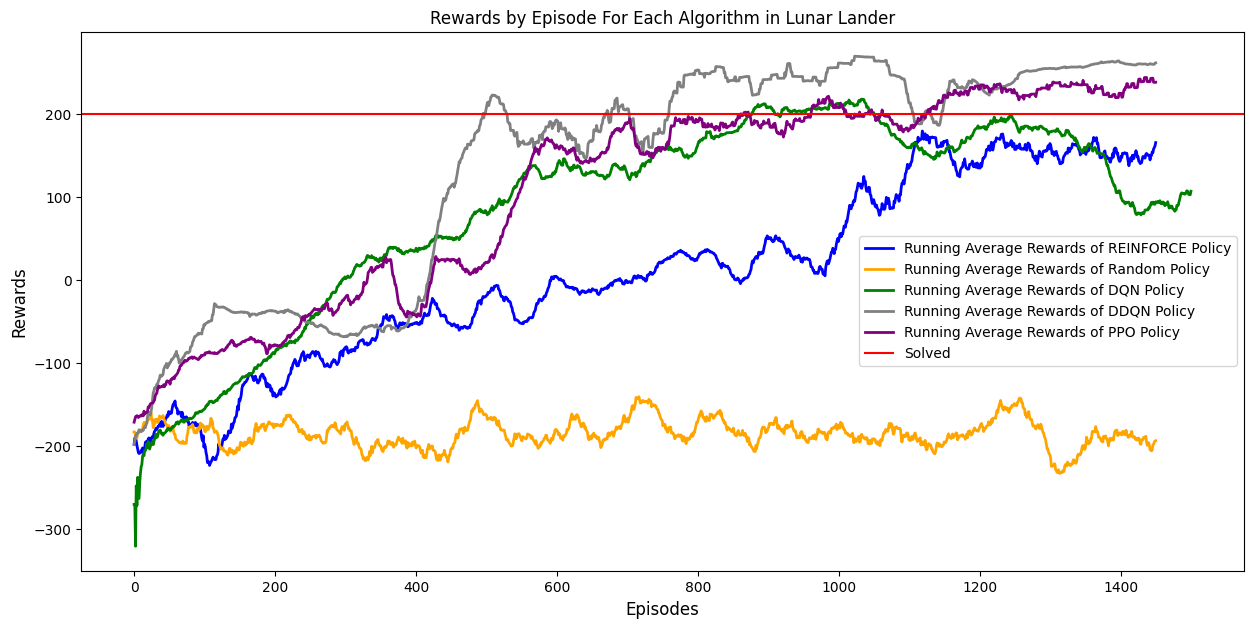

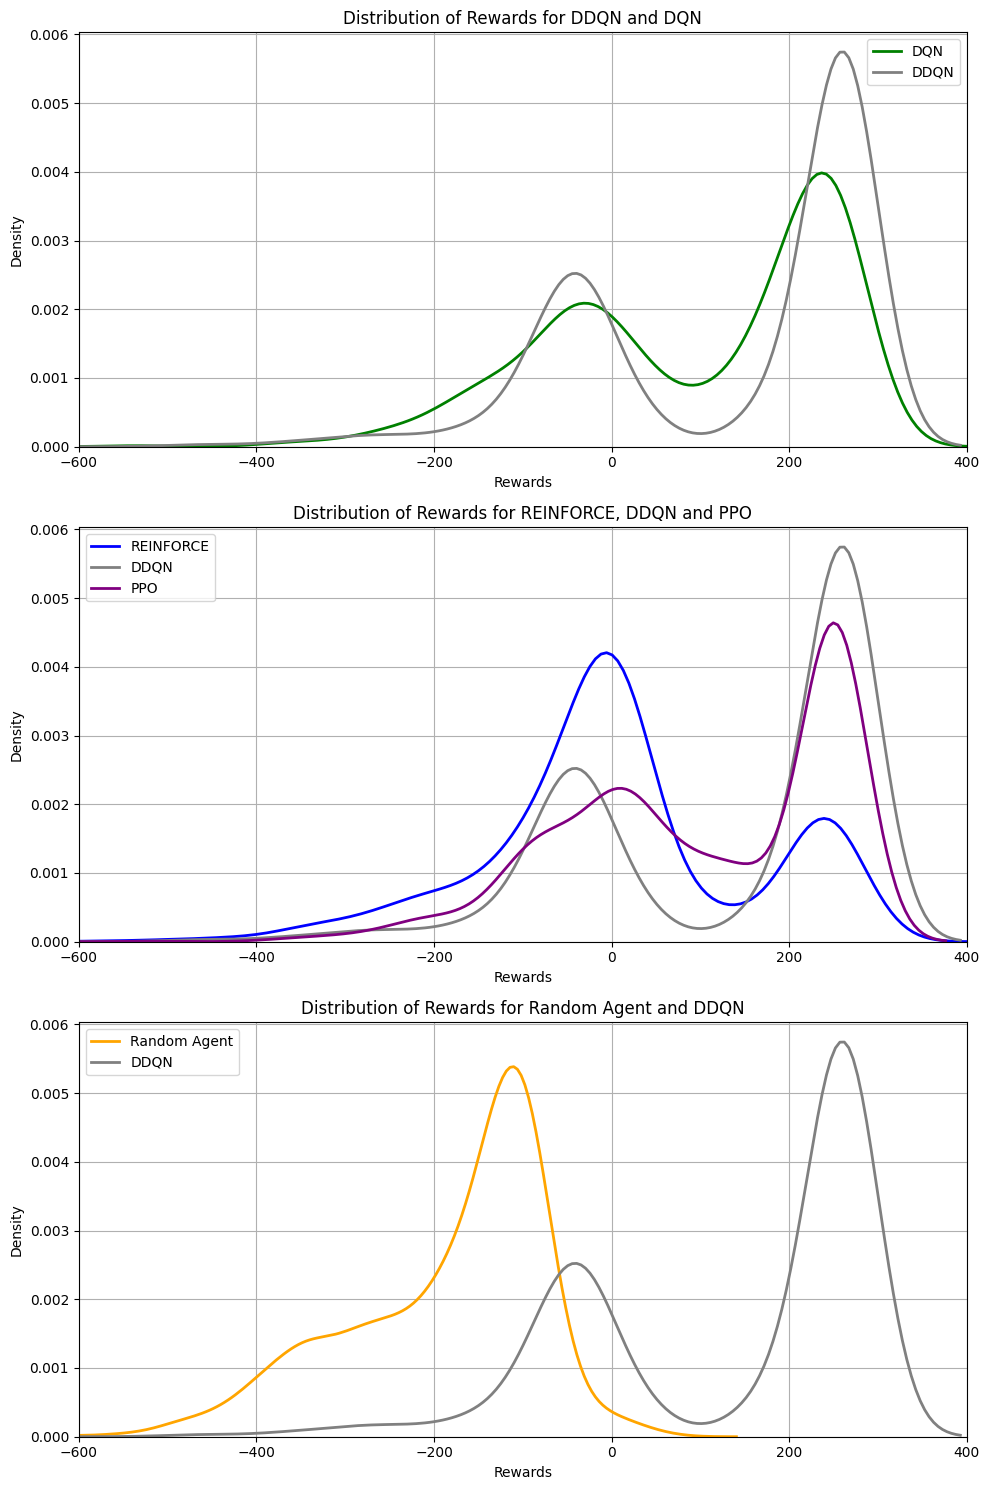

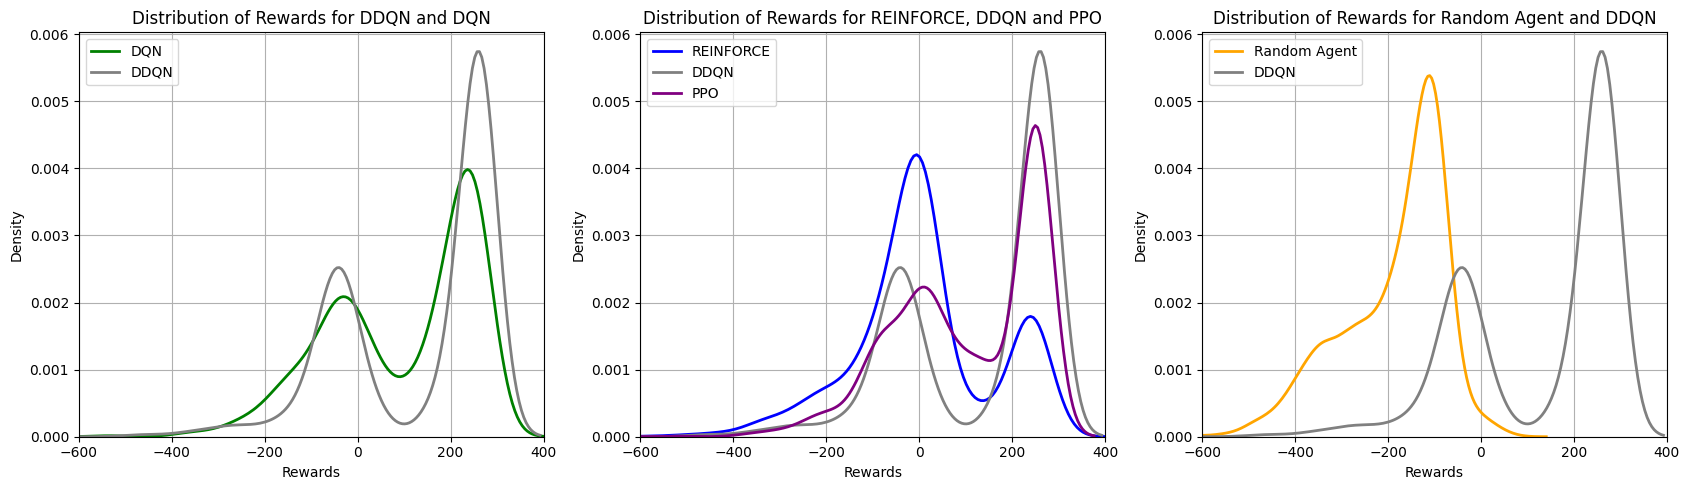

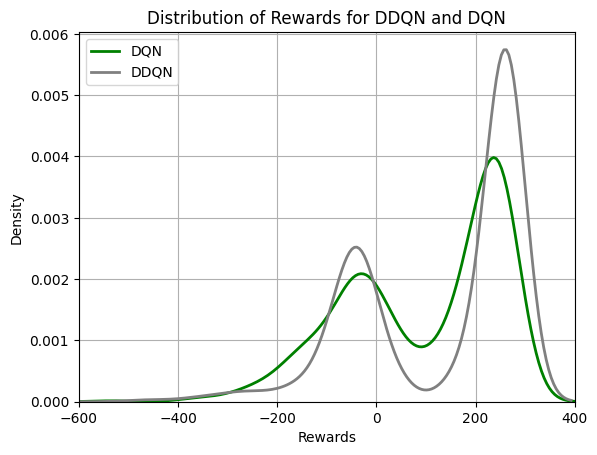

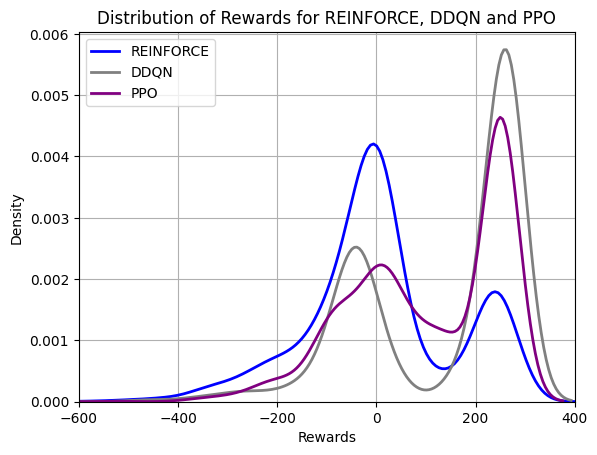

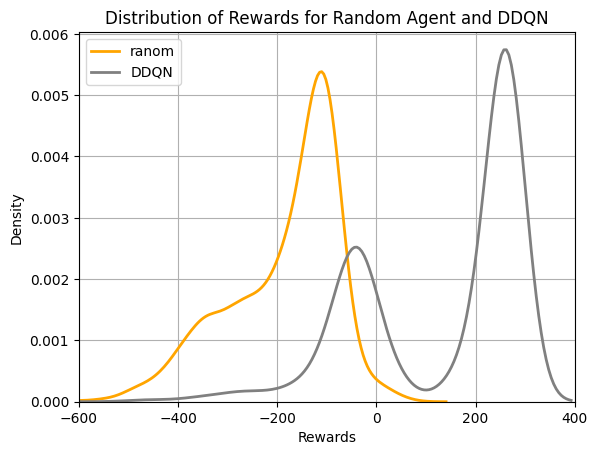

: 

In [59]:
#plotting
import matplotlib.pyplot as plt
import seaborn as sns
#Training plot


plt.figure(figsize=(15,7))
plt.ylabel("Rewards",fontsize=12)
plt.xlabel("Episodes",fontsize=12)
plt.plot(reinforce_mean_rewards, color='blue', linewidth=2,label = 'Running Average Rewards of REINFORCE Policy')
plt.plot(rand_mean_rewards, color='orange', linewidth=2,label = 'Running Average Rewards of Random Policy')
plt.plot(DQN_mean_rewards, color='green', linewidth=2,label = 'Running Average Rewards of DQN Policy')
plt.plot(DDQN_mean_rewards, color='grey', linewidth=2,label = 'Running Average Rewards of DDQN Policy')
plt.plot(PPO_mean_rewards, color='purple', linewidth=2,label = 'Running Average Rewards of PPO Policy')
plt.axhline(y=200, color='r', linestyle='-',label = 'Solved')

plt.legend()

plt.title('Rewards by Episode For Each Algorithm in Lunar Lander')
plt.show()


#DISTRIBUTION PLOTS

# Create subplots long 
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Density plot DDQN VS DQN
sns.kdeplot(rewards_history_DQN, color='green', linewidth=2, label="DQN", ax=axs[0])
sns.kdeplot(rewards_history_DDQN, color='grey', linewidth=2, label="DDQN", ax=axs[0])
axs[0].set_title('Distribution of Rewards for DDQN and DQN')
axs[0].set_xlabel('Rewards')
axs[0].set_ylabel('Density')
axs[0].set_xlim(-600, 400)
axs[0].grid(True)
axs[0].legend()

# Density plot PPO VS DDQN VS REINFORCE
sns.kdeplot(rewards_history_reinforce, color='b', linewidth=2, label="REINFORCE", ax=axs[1])
sns.kdeplot(rewards_history_DDQN, color='grey', linewidth=2, label="DDQN", ax=axs[1])
sns.kdeplot(rewards_history_PPO, color='purple', linewidth=2, label="PPO", ax=axs[1])
axs[1].set_title('Distribution of Rewards for REINFORCE, DDQN and PPO')
axs[1].set_xlabel('Rewards')
axs[1].set_ylabel('Density')
axs[1].set_xlim(-600, 400)
axs[1].grid(True)
axs[1].legend()

# Density plot PPO VS DDQN VS Random Agent
sns.kdeplot(rewards_history_rand, color='orange', linewidth=2, label="Random Agent", ax=axs[2])
sns.kdeplot(rewards_history_DDQN, color='grey', linewidth=2, label="DDQN", ax=axs[2])
axs[2].set_title('Distribution of Rewards for Random Agent and DDQN')
axs[2].set_xlabel('Rewards')
axs[2].set_ylabel('Density')
axs[2].set_xlim(-600, 400)
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()

# Create subplots wide
fig, axs = plt.subplots(1, 3, figsize=(17, 5))

# Density plot DDQN VS DQN
sns.kdeplot(rewards_history_DQN, color='green', linewidth=2, label="DQN", ax=axs[0])
sns.kdeplot(rewards_history_DDQN, color='grey', linewidth=2, label="DDQN", ax=axs[0])
axs[0].set_title('Distribution of Rewards for DDQN and DQN')
axs[0].set_xlabel('Rewards')
axs[0].set_ylabel('Density')
axs[0].set_xlim(-600, 400)
axs[0].grid(True)
axs[0].legend()

# Density plot PPO VS DDQN VS REINFORCE
sns.kdeplot(rewards_history_reinforce, color='b', linewidth=2, label="REINFORCE", ax=axs[1])
sns.kdeplot(rewards_history_DDQN, color='grey', linewidth=2, label="DDQN", ax=axs[1])
sns.kdeplot(rewards_history_PPO, color='purple', linewidth=2, label="PPO", ax=axs[1])
axs[1].set_title('Distribution of Rewards for REINFORCE, DDQN and PPO')
axs[1].set_xlabel('Rewards')
axs[1].set_ylabel('Density')
axs[1].set_xlim(-600, 400)
axs[1].grid(True)
axs[1].legend()

# Density plot PPO VS DDQN VS Random Agent
sns.kdeplot(rewards_history_rand, color='orange', linewidth=2, label="Random Agent", ax=axs[2])
sns.kdeplot(rewards_history_DDQN, color='grey', linewidth=2, label="DDQN", ax=axs[2])
axs[2].set_title('Distribution of Rewards for Random Agent and DDQN')
axs[2].set_xlabel('Rewards')
axs[2].set_ylabel('Density')
axs[2].set_xlim(-600, 400)
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()


# Individual plots
#Density plot DDQN VS DQN 

#sns.kdeplot(rewards_history_reinforce, color='b', linewidth=2,label = "REINFORCE")
#sns.kdeplot(rewards_history_rand, color='orange', linewidth=2, label = "ranom")
sns.kdeplot(rewards_history_DQN, color='green', linewidth=2,label = "DQN")
sns.kdeplot(rewards_history_DDQN, color='grey', linewidth=2, label = "DDQN")
#sns.kdeplot(rewards_history_PPO, color='purple', linewidth=2,label = "PPO")


plt.title('Distribution of Rewards for DDQN and DQN')
plt.xlabel('Rewards')
plt.ylabel('Density')
plt.xlim(-600,400)
plt.grid(True)
plt.legend()
plt.show()

#Density plot PPO VS DDQN VS REINFORCE

sns.kdeplot(rewards_history_reinforce, color='b', linewidth=2,label = "REINFORCE")
#sns.kdeplot(rewards_history_rand, color='orange', linewidth=2, label = "ranom")
#sns.kdeplot(rewards_history_DQN, color='green', linewidth=2,label = "DQN")
sns.kdeplot(rewards_history_DDQN, color='grey', linewidth=2, label = "DDQN")
sns.kdeplot(rewards_history_PPO, color='purple', linewidth=2,label = "PPO")


plt.title('Distribution of Rewards for REINFORCE, DDQN and PPO')
plt.xlabel('Rewards')
plt.ylabel('Density')
plt.xlim(-600,400)
plt.grid(True)
plt.legend()
plt.show()

#Density plot PPO VS DDQN VS REINFORCE

#sns.kdeplot(rewards_history_reinforce, color='b', linewidth=2,label = "REINFORCE")
sns.kdeplot(rewards_history_rand, color='orange', linewidth=2, label = "ranom")
#sns.kdeplot(rewards_history_DQN, color='green', linewidth=2,label = "DQN")
sns.kdeplot(rewards_history_DDQN, color='grey', linewidth=2, label = "DDQN")
#sns.kdeplot(rewards_history_PPO, color='purple', linewidth=2,label = "PPO")


plt.title('Distribution of Rewards for Random Agent and DDQN')
plt.xlabel('Rewards')
plt.ylabel('Density')
plt.xlim(-600,400)
plt.grid(True)
plt.legend()
plt.show()

